In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
my_path = '/content/drive/MyDrive/DeepL/Miniproject_1/'

In [4]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

In [5]:
def psnr(denoised, ground_truth):
    # Peak Signal to Noise Ratio : denoised and ground˙truth have range [0 , 1]
    mse = torch . mean ((denoised - ground_truth ) ** 2)
    return -10 * torch . log10 ( mse + 10** -8)

In [70]:
### For mini-project 1
class Model(nn.Module):
    def __init__(self) -> None:
        ## instantiate model + optimizer + loss function + any other stuff you need
        super().__init__()

        self.encoder = nn.Sequential( # initial: N, 3, 32, 32
            nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0), # N, 3, 16, 16
            nn.Conv2d(3, 64, kernel_size = 5, stride = 1),  # N , 32, 12 , 12
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 4, stride = 1, padding = 0), # N, 128, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 1, padding = 0), # N, 64, 4, 4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 12, 12
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 20, 20
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 24, 24
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size = 5, stride = 1, padding = 0), # N, 64, 28, 28
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size = 5, stride = 1, padding = 0) # N, 3, 32, 32
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.001)
        

    def load_pretrained_model(self ) -> None:
        ## This loads the parameters saved in bestmodel . pth into the model
        pass

    def train(self, train_input, train_target) -> None:
        # : train˙input : tensor of size (N , C , H , W ) containing a noisy version of the images.
        # : train˙target : tensor of size (N , C , H , W ) containing another noisy version of the
        # same images , which only differs from the input by their noise.

        batch_size = 100
        epochs = 500
        epochs_to_print = torch.arange(0,epochs,int(epochs/50))
        total_loss = 0

        for epoch in range(epochs):
            if (epoch in epochs_to_print):
              print(f'Epoch {epoch}/{epochs-1} Training Loss {total_loss}')
            total_loss = 0
            for batch_input, batch_target in zip(train_input.split(batch_size), train_target.split(batch_size)):
                output = self.predict(batch_input)
                loss = self.criterion(output, batch_target)
                total_loss += loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
    def predict(self, test_input) -> torch.Tensor:
        # : test˙input : tensor of size ( N1 , C , H , W ) that has to be denoised by the trained
        # or the loaded network .
        # : returns a tensor of the size ( N1 , C , H , W )
        
        # like the forward method
        
        y = self.encoder(test_input)
        y = self.decoder(y)
        
        return y


In [71]:
def main(training=True,images_to_visualize='train'):

    device = torch.device('cuda')

    # Load the data    
    print('Loading the data...')
    train_input, train_target = torch.load(my_path + 'train_data.pkl')
    test_input, test_target = torch.load(my_path + 'val_data.pkl')
    train_input, train_target = train_input.to(device), train_target.to(device)
    test_input, test_target = test_input.to(device), test_target.to(device)


    # Select a subset to speed up computations
    train_size = 1000
    train_input = train_input[:train_size]
    train_target = train_target[:train_size]
    test_input = test_input[:train_size]
    test_target = test_target[:train_size]


    # Convert the data into float type
    train_input = train_input.float()
    train_target = train_target.float()
    test_input = test_input.float()
    test_target = test_target.float()

    
    print(f'Training data of size {train_input.shape}')

    # Defining and training the model
    model = Model()
    model = model.to(device)
    path_to_model = "/content/drive/MyDrive/DeepL/Miniproject_1/bestmodel.pth"

    if (training == True):
      print('Training the model...')
      model.train(train_input, train_target)
    else:
      checkpoint = torch.load(path_to_model)
      model.load_state_dict(checkpoint)

    # Save the model
    torch.save(model.state_dict(),path_to_model)

    # Testing
    print('Using the trained model to denoise validation images...')
    with torch.no_grad():
        prediction = model.predict(test_input)

    # Evaluating error
    error = psnr(prediction, test_target)
    print(f'The PSNR on the validation set is {error} DB')


    # Visual comparison between original images and reconstructions
    # Just for us, probably we can't use matplotlib
    # Try to see if there are visualization tools only in Pytorch 
    # Set "train" if you want to compare the training images, "test" for testing ones
    if (images_to_visualize != 'no'):
      if (images_to_visualize == "train"):
          with torch.no_grad():
              pred = model.predict(train_input).cpu()
          train_input = train_input.cpu()
          images = train_input
      elif (images_to_visualize == "test"):
          pred = prediction
          test_input = test_input.cpu()
          images = test_input
          pred = pred.cpu()
      else:
          raise RuntimeError("Che cazzo hai messo coglione")
      n_comparisons = 5
      for i in range(n_comparisons):
          f = plt.figure()
          f.add_subplot(1, 2, 1)
          fig1 = plt.imshow(images[i].int().permute(1, 2, 0))
          fig1.axes.get_xaxis().set_visible(False)
          fig1.axes.get_yaxis().set_visible(False)
          f.add_subplot(1, 2, 2)
          fig2 = plt.imshow(pred[i].int().permute(1, 2, 0))
          fig2.axes.get_xaxis().set_visible(False)
          fig2.axes.get_yaxis().set_visible(False)
          plt.show(block=True)

Loading the data...
Training data of size torch.Size([1000, 3, 32, 32])
Training the model...
Epoch 0/499 Training Loss 0
Epoch 10/499 Training Loss 59699.7890625
Epoch 20/499 Training Loss 35510.3828125
Epoch 30/499 Training Loss 31115.580078125
Epoch 40/499 Training Loss 29202.06640625
Epoch 50/499 Training Loss 27524.037109375
Epoch 60/499 Training Loss 26369.43359375
Epoch 70/499 Training Loss 25693.7578125
Epoch 80/499 Training Loss 24955.67578125
Epoch 90/499 Training Loss 24703.69921875
Epoch 100/499 Training Loss 24005.640625
Epoch 110/499 Training Loss 23499.666015625
Epoch 120/499 Training Loss 22872.76171875
Epoch 130/499 Training Loss 22741.15625
Epoch 140/499 Training Loss 22378.125
Epoch 150/499 Training Loss 22020.7265625
Epoch 160/499 Training Loss 22190.08984375
Epoch 170/499 Training Loss 21745.517578125
Epoch 180/499 Training Loss 21001.966796875
Epoch 190/499 Training Loss 20814.06640625
Epoch 200/499 Training Loss 20909.341796875
Epoch 210/499 Training Loss 19916.6

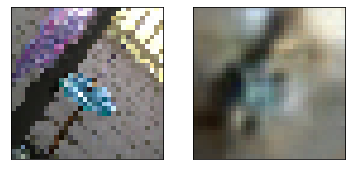

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


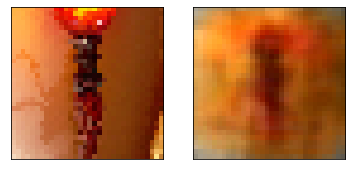

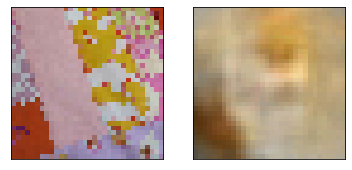

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


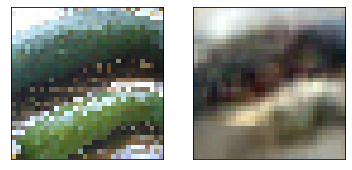

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


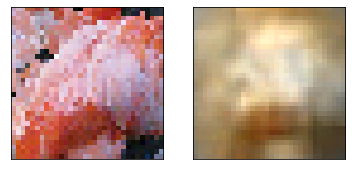

In [72]:
main(training=True,images_to_visualize='train') # images_to_visualize='train','test','no'